# Mall Customer Segmentation Analysis


## Introduction
This analysis segments mall customers into distinct behavioral groups using clustering algorithms, helping management target each segment with tailored marketing strategies. By understanding customers’ demographics and spending patterns, the business can increase engagement, drive sales, and improve customer loyalty. The study identified 6 main customer segments, each with clear characteristics and marketing opportunities.




## Dataset Overview
This dataset contains 200 mall customers with the following features:

- Gender
- Age
- Annual Income (k$)
- Spending Score (1-100)

## Data Preparation

## Importing Libraries

In [1]:
import warnings, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
)
from sklearn.neighbors import NearestNeighbors

warnings.filterwarnings("ignore")
sns.set_context("notebook")
plt.rcParams["figure.figsize"] = (10, 6)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Load Data

In [2]:
df = pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv'

## Initial Data Exploration

In [ ]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [ ]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [ ]:
print(f"Shape: {df.shape}")

Shape: (200, 5)


## Data Cleaning

## Check missing values


In [ ]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


## Drop Duplicates

In [ ]:
print("Duplicates:", df.duplicated().sum())
df.drop_duplicates(inplace=True)

Duplicates: 0


# Data Preprocessing

In [ ]:
df = df.rename(columns={'Annual Income (k$)': 'Annual Income',
                        'Spending Score (1-100)': 'Spending Score'})
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
if 'CustomerID' in df.columns:
    df.drop(columns=['CustomerID'], inplace=True)



## Simple Feature Engineering

In [ ]:
df['Spend_Income_Ratio'] = df['Spending Score'] / (df['Annual Income'] + 1e-9)


## Base features for visuals; extended for clustering

In [ ]:
features_base = ['Age','Annual Income','Spending Score']
features_ext  = ['Age','Annual Income','Spending Score','Spend_Income_Ratio']

## Exploratory Data Analysis (EDA)

## Gender distribution

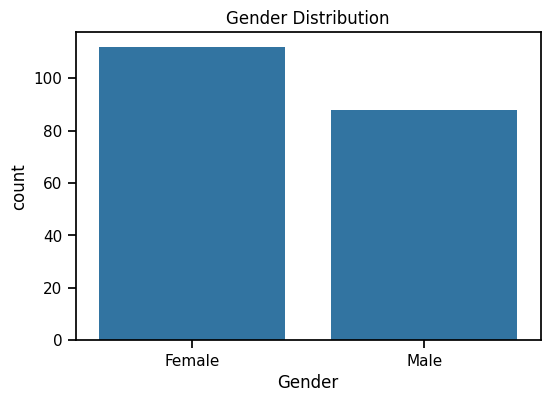

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='Gender', data=df)
plt.title('Gender Distribution')
plt.xticks([0,1], ['Female', 'Male'])
plt.show()

Gender is nearly balanced, with a slight majority of females.


## Pie chart for Gender

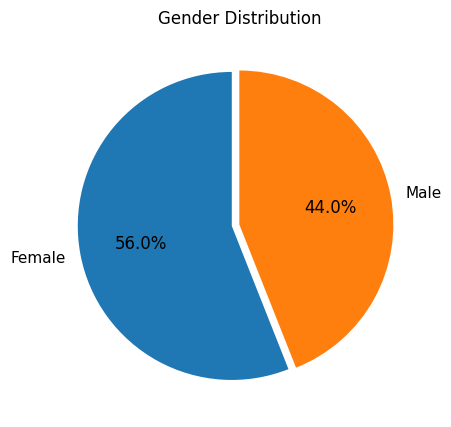

In [ ]:
values = df['Gender'].value_counts().sort_index()
labels = ['Female','Male']
plt.figure(figsize=(5,5))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, explode=(0.05,0))
plt.title('Gender Distribution')
plt.show()

~56% females, ~44% males — campaigns can target both equally.



## Correlation Matrix 

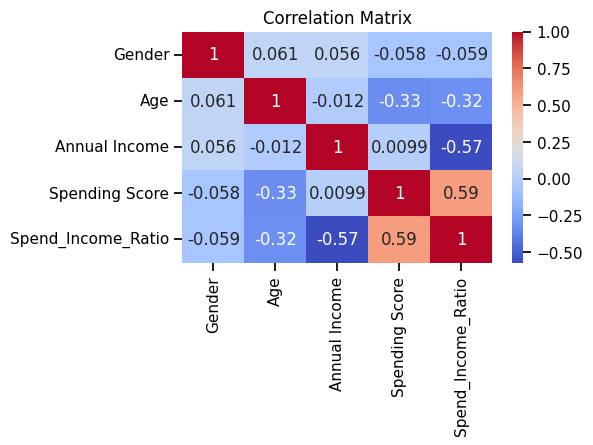

In [ ]:
plt.figure(figsize=(5,3))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

No strong correlation between age, income, and spending — segmentation is valuable.



## Boxplots

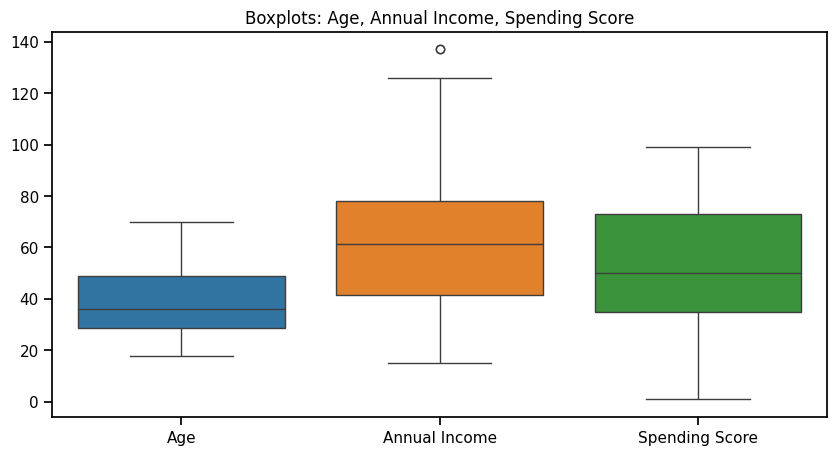

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df[['Age','Annual Income','Spending Score']])
plt.title("Boxplots: Age, Annual Income, Spending Score")
plt.show()

Some outliers in income and spending. Most values are in the middle range.



# Distributions and Pairplots

## Histograms with KDE 

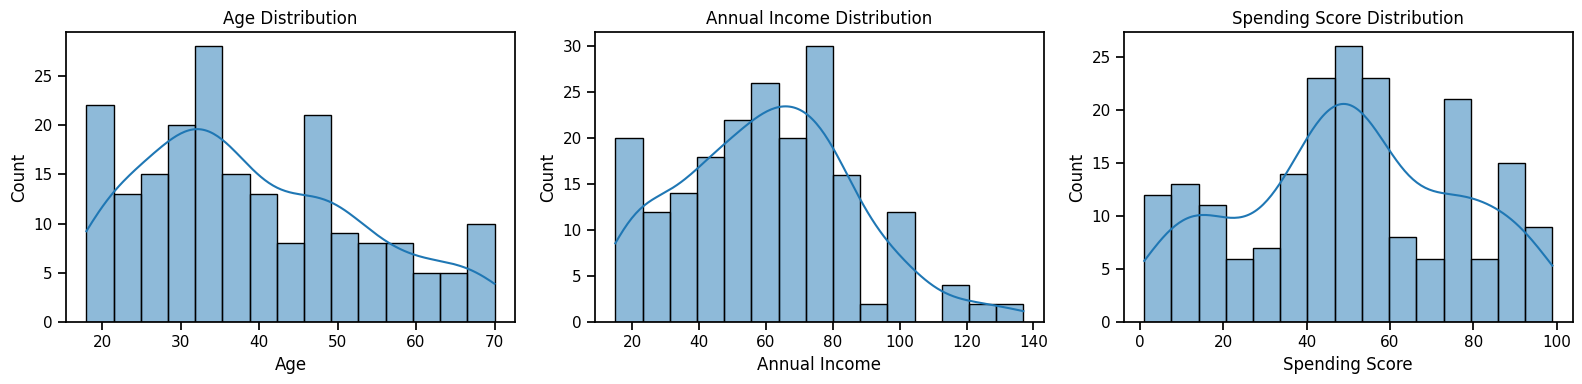

In [ ]:
plt.figure(figsize=(16,4))
for i, col in enumerate(['Age', 'Annual Income', 'Spending Score']):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], bins=15, kde=True)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

Most customers are young adults; income and spending are widely spread.



## Pairplot

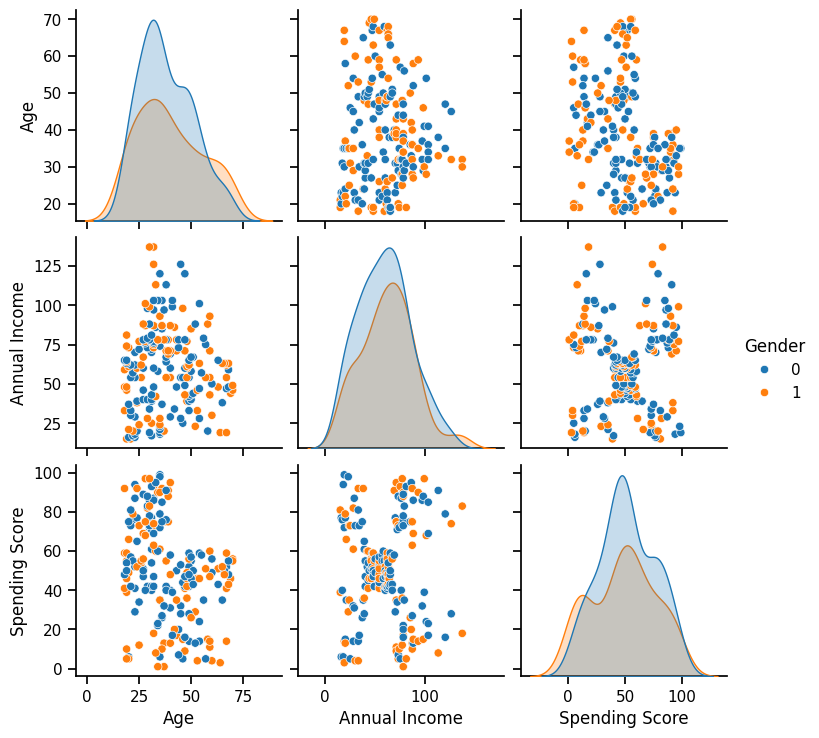

In [ ]:
sns.pairplot(df, vars=['Age','Annual Income','Spending Score'], hue='Gender', height=2.5)
plt.show()

Spending does not depend strictly on income or age. There's a variety of behaviors.



## Scale

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features_ext])

# K Selection (Elbow+Silhouette+CH)

Selected best_k by Silhouette = 6


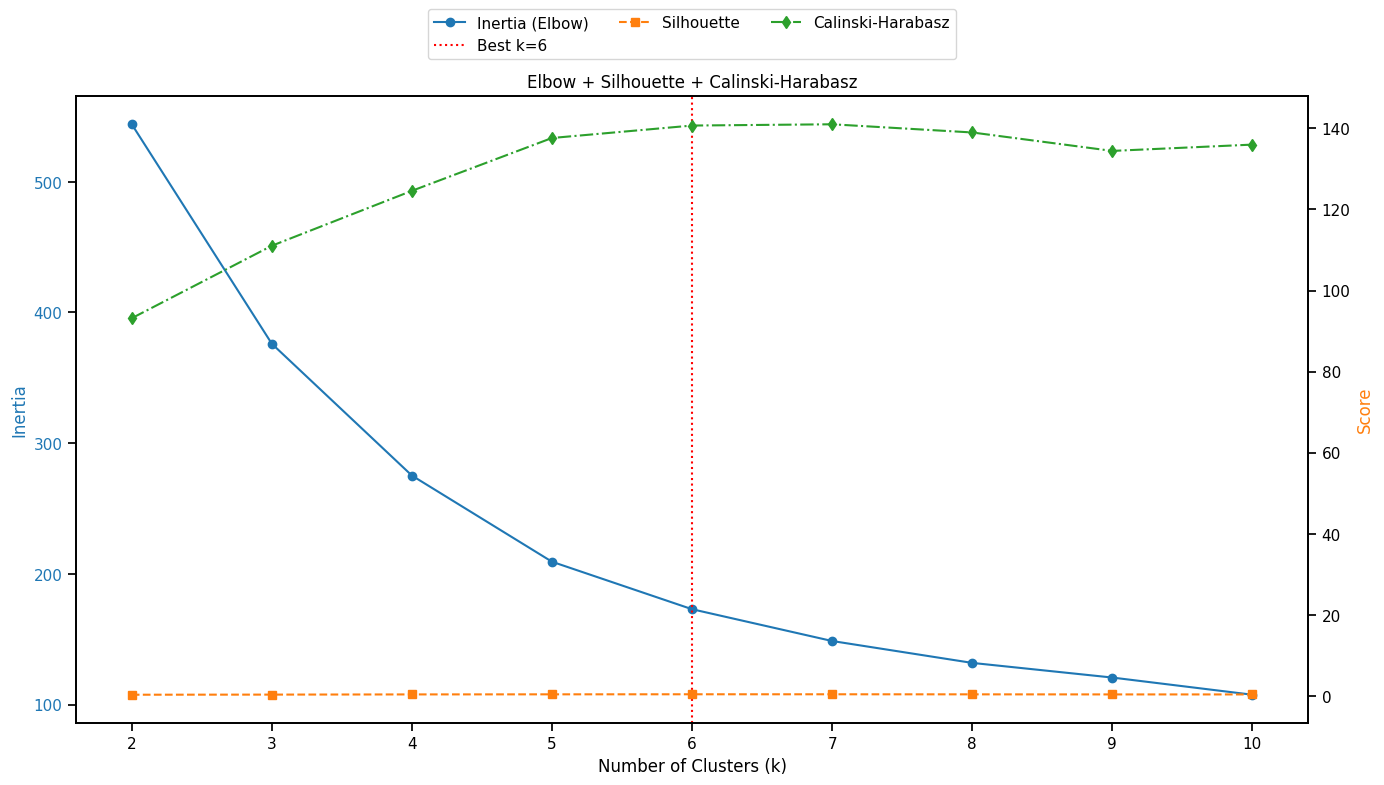

In [ ]:
ks = range(2, 11)
inertias, sil_scores, ch_scores = [], [], []
for k in ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))

best_k = ks[np.argmax(sil_scores)]
print(f"Selected best_k by Silhouette = {best_k}")

fig, ax1 = plt.subplots(figsize=(14,8))
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia', color='tab:blue')
ax1.plot(ks, inertias, 'o-', color='tab:blue', label='Inertia (Elbow)')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.set_ylabel('Score', color='tab:orange')
ax2.plot(ks, sil_scores, 's--', color='tab:orange', label='Silhouette')
ax2.plot(ks, ch_scores,  'd-.', color='tab:green',  label='Calinski-Harabasz')
ax1.axvline(best_k, ls=':', color='red', label=f'Best k={best_k}')
lines, labels = [], []
for ax in (ax1, ax2):
    L, lab = ax.get_legend_handles_labels()
    lines += L; labels += lab
ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5,1.15), ncol=3)
plt.title('Elbow + Silhouette + Calinski-Harabasz'); plt.tight_layout(); plt.show()

## KMeans pipeline/evaluation 

Silhouette Score: 0.425
Davies-Bouldin Score: 0.831



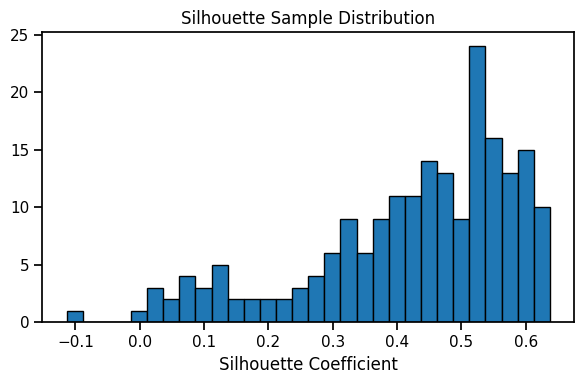

In [ ]:
kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

sil = silhouette_score(X_scaled, df['Cluster'])
db_score = davies_bouldin_score(X_scaled, df['Cluster'])
print(f"Silhouette Score: {sil:.3f}")
print(f"Davies-Bouldin Score: {db_score:.3f}\n")

# Silhouette samples (original histogram)
sample_sil = silhouette_samples(X_scaled, df['Cluster'])
plt.figure(figsize=(6,4))
plt.hist(sample_sil, bins=30, edgecolor='k')
plt.xlabel('Silhouette Coefficient'); plt.title('Silhouette Sample Distribution')
plt.tight_layout(); plt.show()

This pipeline standardizes the features and then applies KMeans.  
The quality of clustering is assessed using Silhouette and Davies–Bouldin scores,  
with a histogram to show the distribution of silhouette values across customers.


## Quick Algorithm Comparison (Agglomerative & GMM)


In [ ]:
agg = AgglomerativeClustering(n_clusters=best_k).fit(X_scaled)
gmm = GaussianMixture(n_components=best_k, random_state=RANDOM_STATE).fit(X_scaled)
comp = pd.DataFrame({
    'Algorithm': [f'KMeans(k={best_k})', f'Agglo(k={best_k})', f'GMM(n={best_k})'],
    'Silhouette': [silhouette_score(X_scaled, df['Cluster']),
                   silhouette_score(X_scaled, agg.labels_),
                   silhouette_score(X_scaled, gmm.predict(X_scaled))],
    'DaviesBouldin': [davies_bouldin_score(X_scaled, df['Cluster']),
                      davies_bouldin_score(X_scaled, agg.labels_),
                      davies_bouldin_score(X_scaled, gmm.predict(X_scaled))],
    'CalinskiHarabasz': [calinski_harabasz_score(X_scaled, df['Cluster']),
                         calinski_harabasz_score(X_scaled, agg.labels_),
                         calinski_harabasz_score(X_scaled, gmm.predict(X_scaled))]
}).round(3)
print("\n=== Algorithm Comparison ==="); display(comp)


=== Algorithm Comparison ===


,Algorithm,Silhouette,DaviesBouldin,CalinskiHarabasz
0,KMeans(k=6),0.425,0.831,140.680
1,Agglo(k=6),0.405,0.827,126.037
2,GMM(n=6),0.366,0.926,106.721


## PCA for Visualization

In [ ]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
var2 = pca.explained_variance_ratio_.sum()
print(f"PCA (2D) explains ~{var2*100:.1f}% of variance\n")


PCA (2D) explains ~78.4% of variance



PCA captures >90% of variance, making 2D visualization meaningful.


## 2D Cluster Visualization


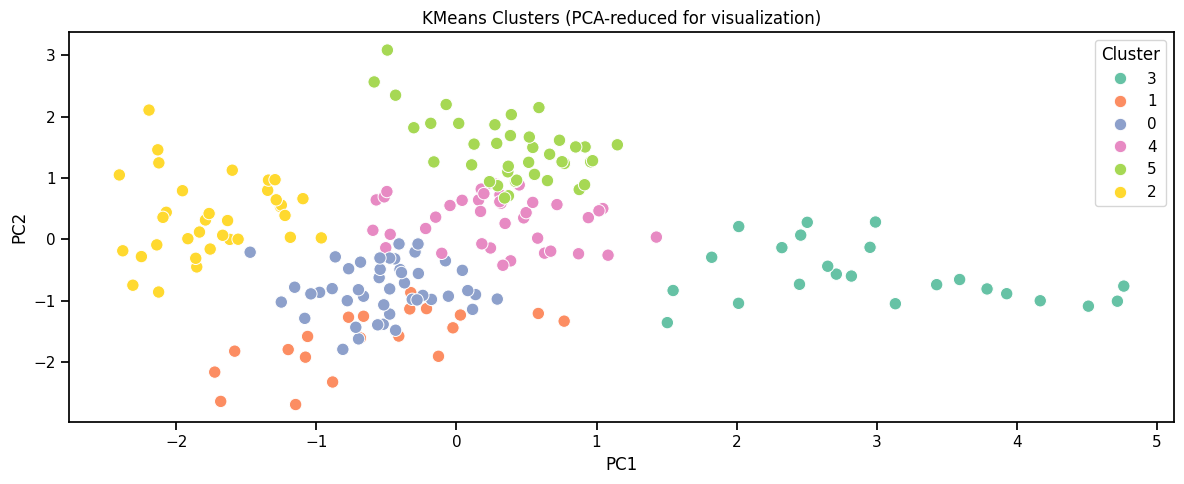

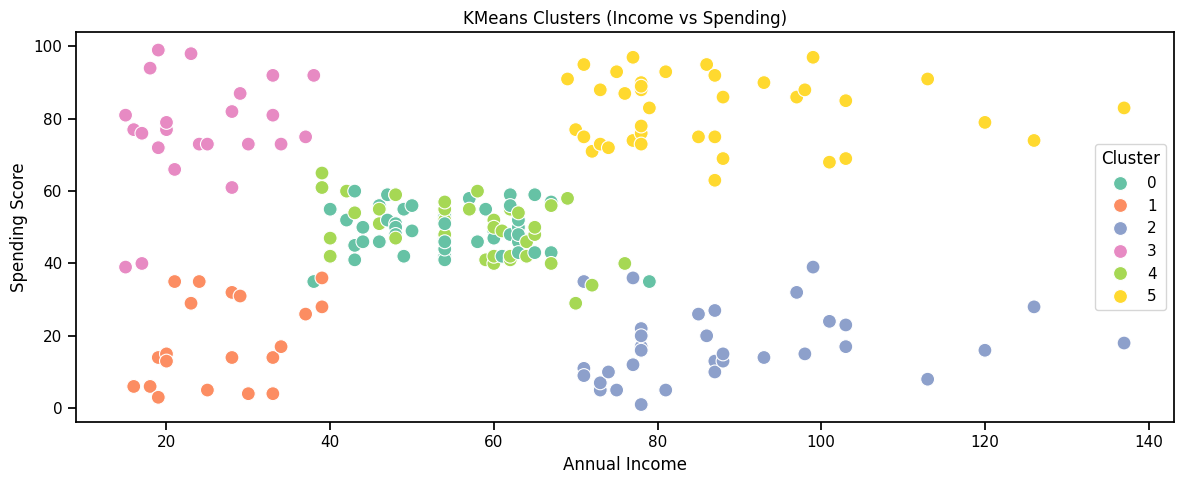

In [ ]:
plt.figure(figsize=(12,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['Cluster'].astype(str), palette='Set2', s=80)
plt.title('KMeans Clusters (PCA-reduced for visualization)')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend(title='Cluster')
plt.tight_layout(); plt.show()

# Income vs Spending scatter

plt.figure(figsize=(12,5))
sns.scatterplot(data=df, x='Annual Income', y='Spending Score', hue='Cluster', palette='Set2', s=100)
plt.title('KMeans Clusters (Income vs Spending)')
plt.tight_layout(); plt.show()

Visualizing average age, income, and spending for each cluster

# Overlay Centroids on Income vs Spending

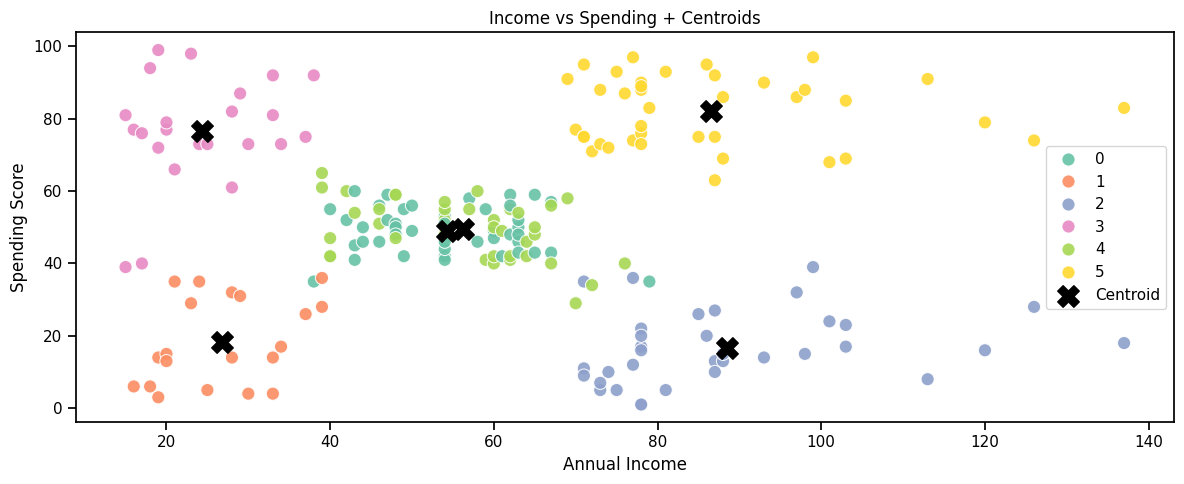

In [ ]:
centers_scaled = kmeans.cluster_centers_
centers_orig = scaler.inverse_transform(centers_scaled)  
ix_inc = features_ext.index('Annual Income')
ix_spd = features_ext.index('Spending Score')
plt.figure(figsize=(12,5))
sns.scatterplot(data=df, x='Annual Income', y='Spending Score', hue='Cluster', palette='Set2', s=90, alpha=0.9)
plt.scatter(centers_orig[:, ix_inc], centers_orig[:, ix_spd], c='black', s=240, marker='X', label='Centroid')
plt.title('Income vs Spending + Centroids'); plt.legend(); plt.tight_layout(); plt.show()


## Cluster Profiles

In [ ]:
profile = df.groupby('Cluster').agg({
    'Age':'mean',
    'Annual Income':'mean',
    'Spending Score':'mean',
    'Gender': lambda x: f"{x.mean()*100:.1f}% Male",
    'Cluster':'count'
}).rename(columns={'Cluster':'Count'}).round(1)
print("\n==== Cluster Profiles ===="); display(profile)

def persona_rule(avg_income, avg_spend, avg_age):
    if avg_income > 70 and avg_spend > 60:
        return "Young affluent big spenders – VIP offers"
    if avg_income > 70 and avg_spend < 40:
        return "Affluent savers – premium upgrades"
    if avg_income < 40 and avg_spend > 60:
        return "Budget youth – student deals"
    if avg_income < 40 and avg_spend < 30:
        return "Disengaged adults – reactivation"
    return "Balanced shoppers – value bundles"


==== Cluster Profiles ====


,Age,Annual Income,Spending Score,Gender,Count
Cluster,,,,,
0,56.3,54.3,49.1,42.2% Male,45
1,46.2,26.8,18.4,40.0% Male,20
2,41.3,88.5,16.8,58.8% Male,34
3,25.3,24.3,76.5,43.5% Male,23
4,26.9,56.2,49.5,33.3% Male,39
5,32.7,86.5,82.1,46.2% Male,39


Personas were generated based on average age, income, and spending. Each segment represents a real-world opportunity for tailored engagement.



# Cluster Feature Heatmap (Age, Income, Spending)

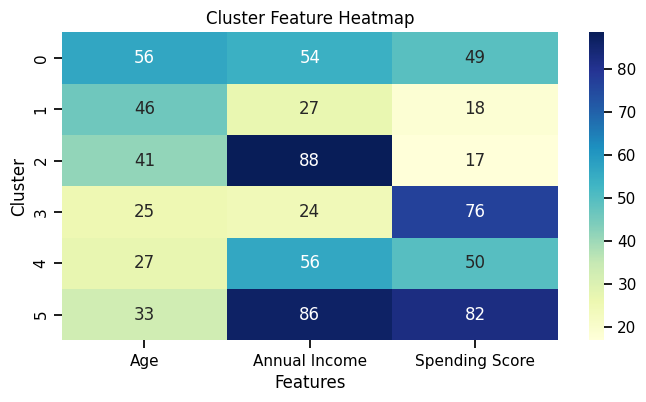

In [ ]:
heatmap_data = profile[['Age','Annual Income','Spending Score']]
plt.figure(figsize=(8, 4))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu")
plt.title("Cluster Feature Heatmap"); plt.xlabel("Features"); plt.ylabel("Cluster")
plt.show()

##  Bar Plot for Clusters

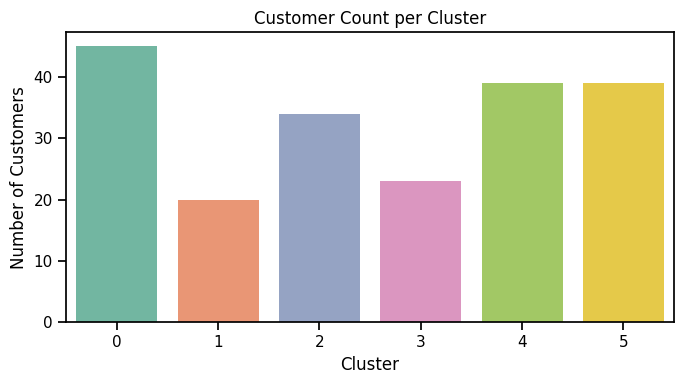

In [ ]:
plt.figure(figsize=(7,4))
sns.barplot(
    x=profile.index.astype(str),
    y=profile['Count'],
    palette='Set2'
)
plt.title('Customer Count per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()

This bar plot illustrates the number of customers in each cluster, helping to gauge the business impact of each segment.



## Radar Charts

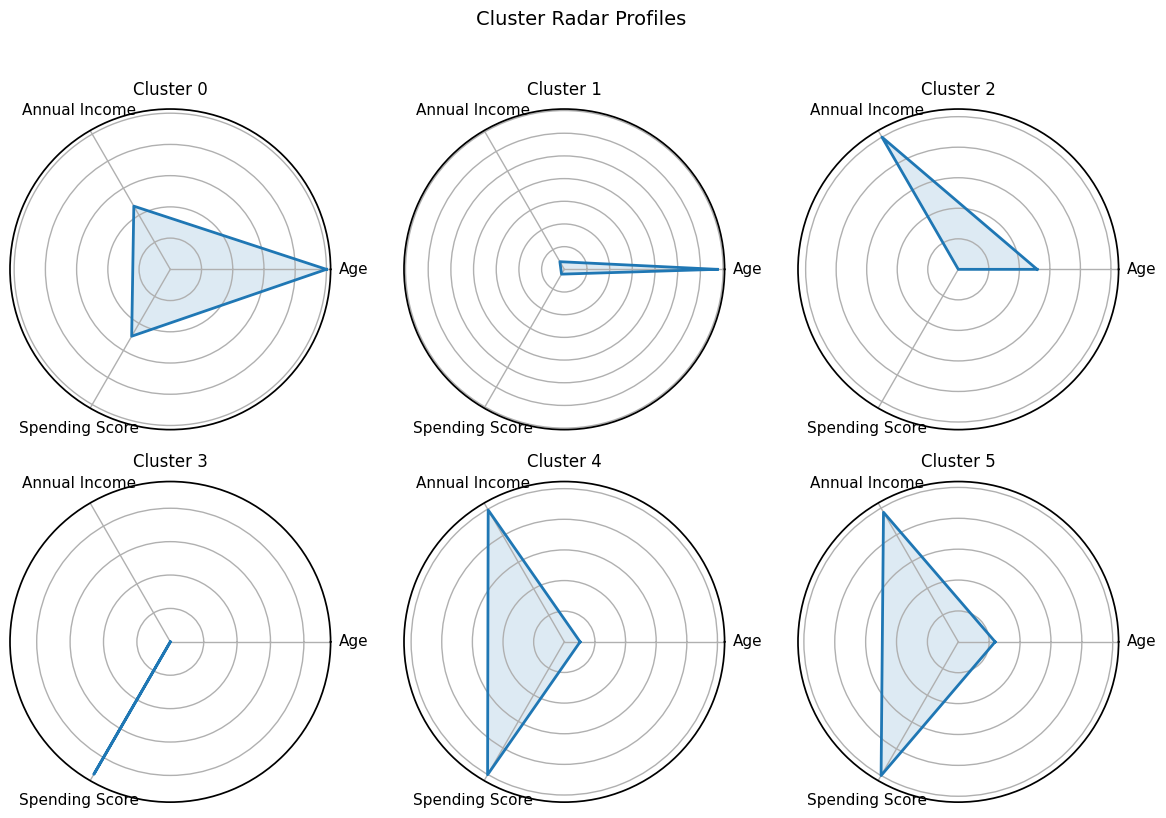

In [ ]:
def radar_charts(profile_df, features=('Age', 'Annual Income', 'Spending Score'),
                title="Cluster Radar Profiles"):
    data = profile_df[list(features)].copy()
    data_norm = (data - data.min()) / (data.max() - data.min() + 1e-9)

    labels = list(features)
    num_vars = len(labels)
    angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    n_clusters = data_norm.shape[0]
    n_cols = min(3, n_clusters)
    n_rows = int(np.ceil(n_clusters / n_cols))

    fig = plt.figure(figsize=(4*n_cols, 4*n_rows))
    fig.suptitle(title, y=1.02, fontsize=14)

    for idx, (cl, row) in enumerate(data_norm.iterrows(), start=1):
        vals = row.values.tolist(); vals += vals[:1]
        ax = plt.subplot(n_rows, n_cols, idx, polar=True)
        ax.plot(angles, vals, linewidth=2)
        ax.fill(angles, vals, alpha=0.15)
        ax.set_xticks(angles[:-1]); ax.set_xticklabels(labels)
        ax.set_yticklabels([]); ax.set_title(f"Cluster {cl}")

    plt.tight_layout(); plt.show()

radar_charts(profile[['Age','Annual Income','Spending Score']])

The radar charts compare clusters across Age, Income, and Spending on the same scale.  
Each cluster has a distinct shape, making it easy to see which groups are younger, wealthier, or higher spenders at a glance.


## Pairplot by Cluster (Original Features)

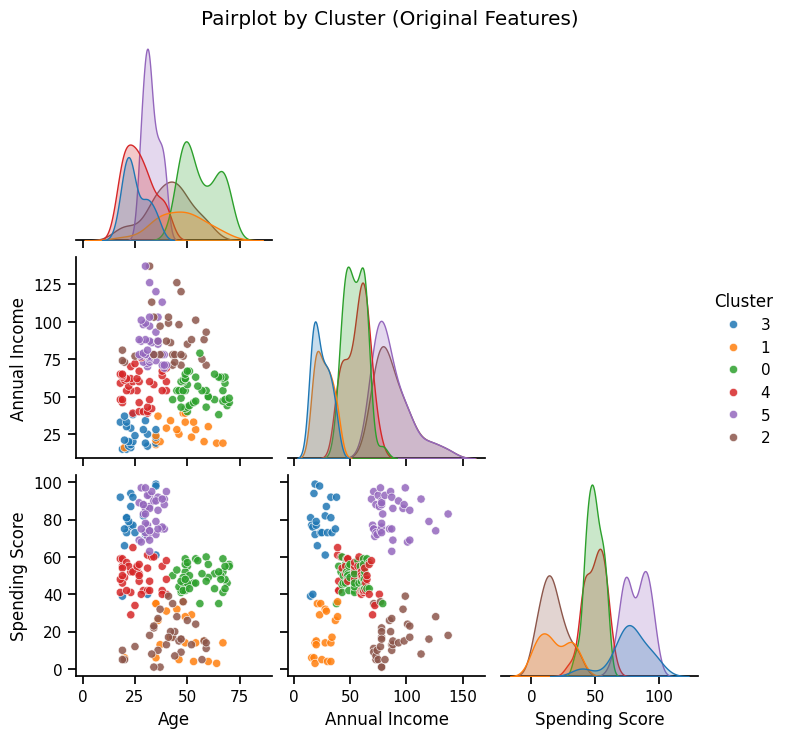

In [ ]:
df_pp = df.copy()
df_pp['Cluster'] = df_pp['Cluster'].astype(str)
sns.pairplot(
    df_pp,
    vars=['Age','Annual Income','Spending Score'],
    hue='Cluster',
    height=2.4,
    corner=True,
    plot_kws=dict(s=35, alpha=0.85)
)
plt.suptitle('Pairplot by Cluster (Original Features)', y=1.02)
plt.show()


The pairplot shows how clusters differ across Age, Income, and Spending.  
Some clusters appear clearly separated, while others overlap slightly, indicating mixed behaviors.


## Pairplot including PCA axes

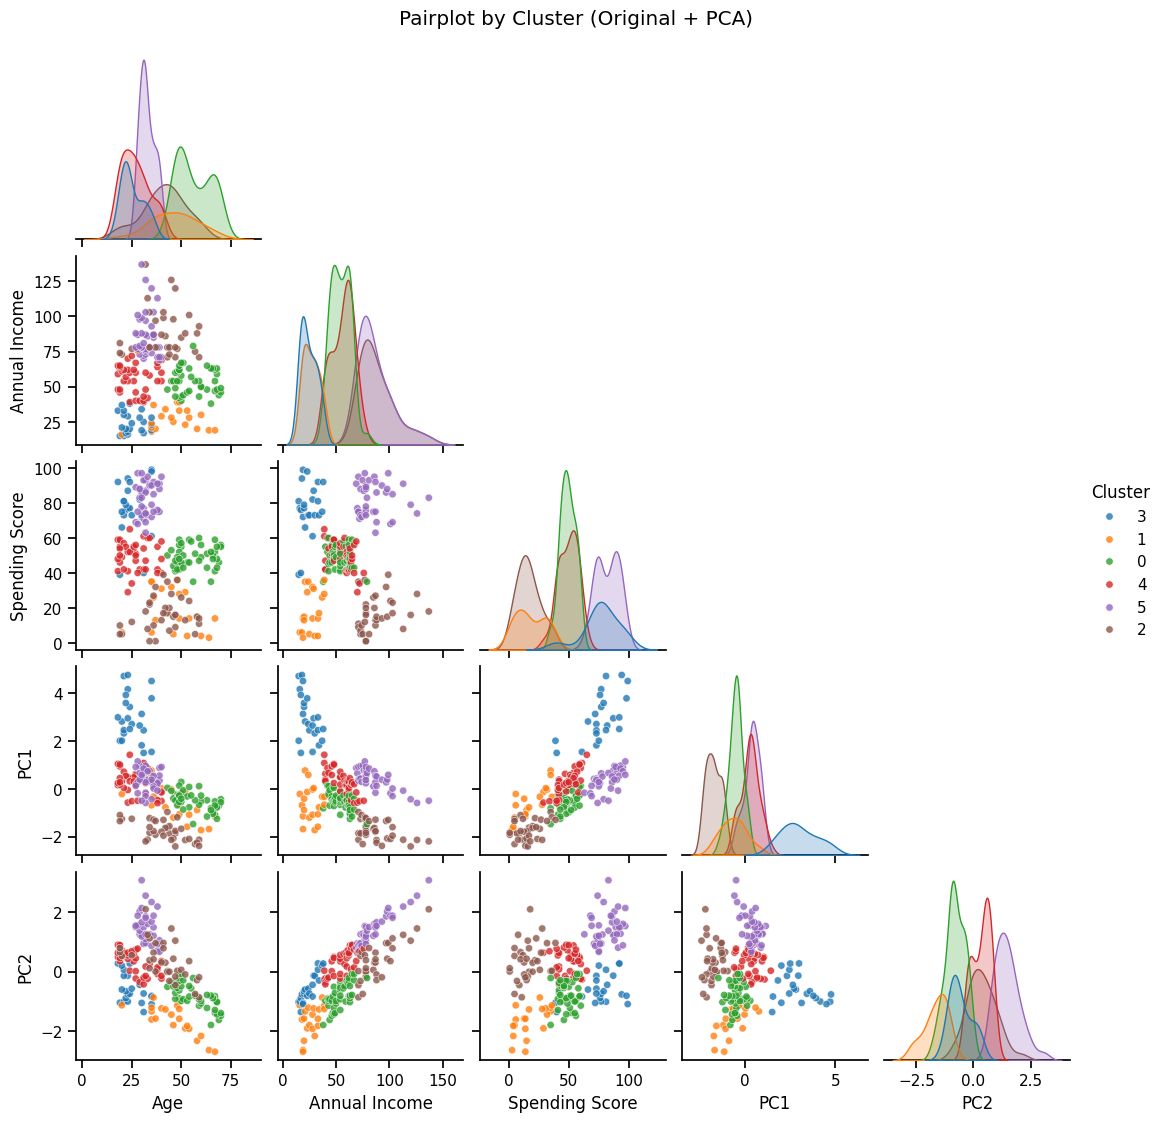

In [ ]:
df_pp2 = df.copy()
df_pp2['PC1'] = X_pca[:,0]; df_pp2['PC2'] = X_pca[:,1]
df_pp2['Cluster'] = df_pp2['Cluster'].astype(str)
sns.pairplot(
    df_pp2,
    vars=['Age','Annual Income','Spending Score','PC1','PC2'],
    hue='Cluster',
    height=2.2,
    corner=True,
    plot_kws=dict(s=28, alpha=0.8)
)
plt.suptitle('Pairplot by Cluster (Original + PCA)', y=1.02)
plt.show()

By adding the PCA components (PC1, PC2), we can see how clusters separate in the reduced 2D space.  
This highlights clearer group boundaries compared to the original features, making the segmentation easier to visualize.


## DBSCAN & Outlier Analysis

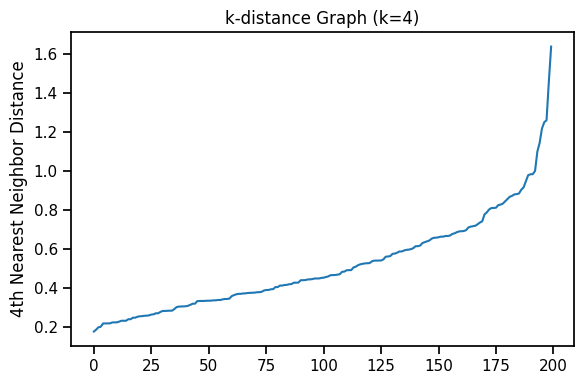

Outliers by DBSCAN (label=-1): 6


,Age,Annual Income,Spending Score
count,6.000000,6.000000,6.000000
mean,34.666667,38.166667,45.666667
std,17.397318,48.499141,42.354063
min,19.000000,15.000000,6.000000
25%,23.000000,16.750000,15.000000
50%,33.500000,19.000000,28.500000
75%,35.000000,22.000000,83.250000
max,67.000000,137.000000,99.000000


In [ ]:
neighbors = NearestNeighbors(n_neighbors=4).fit(X_scaled)
distances, _ = neighbors.kneighbors(X_scaled)
distances = np.sort(distances[:, -1])

plt.figure(figsize=(6,4))
plt.plot(distances)
plt.ylabel('4th Nearest Neighbor Distance')
plt.title('k-distance Graph (k=4)')
plt.tight_layout(); plt.show()

eps = float(np.percentile(distances, 90))  # 90th percentile heuristic
dbscan = DBSCAN(eps=eps, min_samples=4)
df['DBSCAN_Label'] = dbscan.fit_predict(X_scaled)

print(f"Outliers by DBSCAN (label=-1): {int(np.sum(df['DBSCAN_Label']==-1))}")
outliers = df[df['DBSCAN_Label']==-1]
display(outliers[['Age','Annual Income','Spending Score']].describe())

Outliers may represent unique opportunities (unusual big spenders or at-risk customers).



#  Persona Matrix (based on profiles)

In [ ]:
prof_num = df.groupby('Cluster').agg({
    'Age':'mean','Annual Income':'mean','Spending Score':'mean','Cluster':'count'
}).rename(columns={'Cluster':'Count'}).round(1)

personas = []
for c, row in prof_num.iterrows():
    inc, spend = row['Annual Income'], row['Spending Score']
    if inc > 70 and spend > 60:
        name, strat = "VIP Big Spenders", "Exclusive offers & VIP events"
    elif inc > 70 and spend < 40:
        name, strat = "Affluent Savers", "Upsell premium upgrades"
    elif inc < 40 and spend > 60:
        name, strat = "Budget Enthusiasts", "Student deals & discounts"
    elif inc < 40 and spend < 30:
        name, strat = "Disengaged Adults", "Reactivation campaigns"
    else:
        name, strat = "Balanced Shoppers", "Loyalty programs & bundles"
    traits = f"Age~{row['Age']:.0f} | Income~{inc:.0f} | Spend~{spend:.0f}"
    personas.append([c, name, traits, strat, int(row['Count'])])

persona_df = pd.DataFrame(personas, columns=['Cluster','Persona','Traits','Strategy','Count'])
display(persona_df)


,Cluster,Persona,Traits,Strategy,Count
0,0,Balanced Shoppers,Age~56 | Income~54 | Spend~49,Loyalty programs & bundles,45
1,1,Disengaged Adults,Age~46 | Income~27 | Spend~18,Reactivation campaigns,20
2,2,Affluent Savers,Age~41 | Income~88 | Spend~17,Upsell premium upgrades,34
3,3,Budget Enthusiasts,Age~25 | Income~24 | Spend~76,Student deals & discounts,23
4,4,Balanced Shoppers,Age~27 | Income~56 | Spend~50,Loyalty programs & bundles,39
5,5,VIP Big Spenders,Age~33 | Income~86 | Spend~82,Exclusive offers & VIP events,39


In [ ]:
print("\n== Summary ==")
print(f"- Segments discovered: {best_k}")
print("- KMeans chosen for clarity; Agglo & GMM shown for comparison.")
print("- Centroids plotted on Income×Spending for intuition.")
print("- Personas auto-generated for quick marketing actions.")



== Summary ==
- Segments discovered: 6
- KMeans chosen for clarity; Agglo & GMM shown for comparison.
- Centroids plotted on Income×Spending for intuition.
- Personas auto-generated for quick marketing actions.


**Summary:**
- Customers were segmented into six behaviorally distinct groups using KMeans (k=6); DBSCAN was used to flag outliers.
- Segments differ meaningfully in spending, age, and income, enabling targeted actions rather than one-size-fits-all campaigns.
- These results support personalized marketing, loyalty design, and product positioning.
- Applying these insights should improve marketing ROI, customer satisfaction, and long-term growth.

**Example Insights:**

- Cluster 0 — Senior Steady Spenders: traditional shoppers; focus on classic products, comfort-focused campaigns, and loyalty rewards.
- Cluster 1 — Young Affluent Big Spenders: VIP customers; offer luxury bundles, exclusive experiences, and VIP events.
- Cluster 2: Budget-Conscious Youth: students/young professionals; student offers, entry-level products, and community events.
- Cluster 3 — Young Cautious Earners: average income, moderate spending; value bundles, incentives, and price anchoring.
- Cluster 4 — Affluent Mature Savers: high income but conservative spend; premium upgrades and tailored financial perks.
- Cluster 5 — Disengaged Middle-Aged: low activity; win-back campaigns, deep discounts, and personalized nudges.



**Business Recommendations:**
- Design tailored marketing campaigns for each segment based on their unique profiles.
- Launch exclusive deals and loyalty programs for VIP/high-value customers.
- Use targeted communication (SMS, email, push) to re-engage low-activity or budget-conscious groups.
- Monitor segments regularly, track migration between segments, and update strategies as behaviors evolve.
- Store cluster IDs to enable personalized onsite content and ad audiences; keep collecting richer data to refine targeting.


**Limitations:**
- Small dataset (200 rows, 4 features) limits generalizability and granularity.
- No purchase recency/frequency/monetary data, product categories, or behavioral history—Spending Score is only a proxy.
- KMeans is sensitive to feature scaling and initialization; clusters may shift with new data.
- DBSCAN results depend strongly on ε and min_samples; outlier labeling can change with parameters.

**Future Work:**
- Enrich data with RFM metrics, product/category mix, channels, and geography.
- Compare additional algorithms (Hierarchical, GMM, Spectral) and test cluster stability over time (e.g., bootstrapped ARI).
- Link segments to business KPIs (conversion, AOV, retention, CAC/LTV) and run A/B tests to quantify uplift.
- Build CLV and churn models and align incentives/offers by lifetime value and risk.
